In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

import xgboost as xgb

In [112]:
# Load the data from the CSV file
df = pd.read_csv("../datasets/kangaroo-cleaned.csv")

# Display the first few rows to verify the data was loaded correctly
df.head(5)

,type,subtype,bedroomCount,bathroomCount,postCode,habitableSurface,hasBasement,hasDressingRoom,buildingCondition,buildingConstructionYear,...,hasArmoredDoor,hasVisiophone,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,price,epc_kwh
0,0,4.0,2.0,1.0,426397.0,100.0,1,0,3.0,2004.0,...,0,1,0,1.0,0,0,1,7.0,399000.0,175.0
1,0,4.0,2.0,1.0,426397.0,87.0,0,0,5.0,1970.0,...,0,0,0,1.0,0,0,1,2.0,465000.0,425.0
2,0,4.0,2.0,2.0,426397.0,104.0,0,0,5.0,2018.0,...,1,1,0,2.0,0,0,1,3.0,590000.0,125.0
3,0,4.0,1.0,1.0,426397.0,71.0,0,0,5.0,1906.0,...,0,0,0,1.0,0,0,0,0.0,289000.0,325.0
4,0,4.0,2.0,1.0,426397.0,90.0,1,0,2.0,1958.0,...,0,0,0,1.0,0,0,1,2.0,375000.0,225.0


Get relevant features 

In [113]:
# Calculate the correlation matrix, excluding propertyId
correlation_matrix = df.corr()
price_correlations = correlation_matrix['price'].abs().sort_values(ascending=False)

features = price_correlations[price_correlations > 0.09].index.tolist() #list top correlated features 
features = features[1:] # remove price from the list of features

features

['habitableSurface',
 'postCode',
 'toiletCount',
 'bedroomCount',
 'kitchenType',
 'subtype',
 'buildingCondition',
 'epc_kwh',
 'hasPhotovoltaicPanels',
 'hasHeatPump',
 'facedeCount',
 'landSurface',
 'type',
 'hasOffice',
 'terraceSurface',
 'hasDressingRoom',
 'parkingCountOutdoor',
 'hasFireplace',
 'buildingConstructionYear',
 'hasTerrace',
 'hasThermicPanels',
 'hasSwimmingPool']

Prepare for regression + Standardize scales

In [114]:
target = 'price'

x = df[features]
y = df[target]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

---
## Option 1: Linear Regression Coefficients (for linear relationships)

<Axes: title={'center': 'Linear Regression Feature Importance'}>

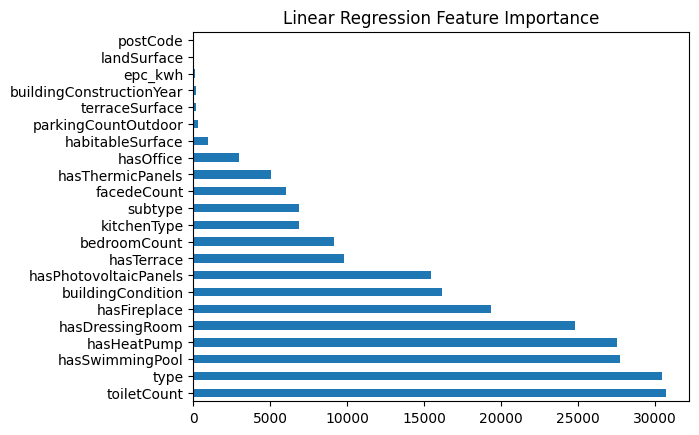

In [115]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Get importance from coefficients (absolute values give relative importance)
importance = pd.Series(np.abs(lr.coef_), index=features)
importance.sort_values(ascending=False).plot(kind='barh', title='Linear Regression Feature Importance')

## Evaluate Model

In [116]:
y_pred = lr.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAPE:", np.mean(np.abs((y_test - y_pred) / y_test)) * 100, "%")
print("MAE:", np.mean(np.abs(y_test - y_pred)))

RMSE: 91685.17502680635
R² Score: 0.657606894045411
MAPE: 22.34477463067516 %
MAE: 67791.46234105511


---

## Option 2: XGBoost
XGBoost (eXtreme Gradient Boosting) is another powerful ensemble learning technique that often outperforms both linear regression and random forest models. It uses gradient boosting with regularization to reduce overfitting and improve performance.

Key advantages of XGBoost:
- High performance and efficient computation
- Regularization to prevent overfitting
- Handles missing values automatically
- Supports parallel processing
- Offers built-in cross-validation

For our housing price prediction task, XGBoost can capture complex non-linear relationships while maintaining good generalization performance.

<Axes: title={'center': 'XGBoost Feature Importance'}>

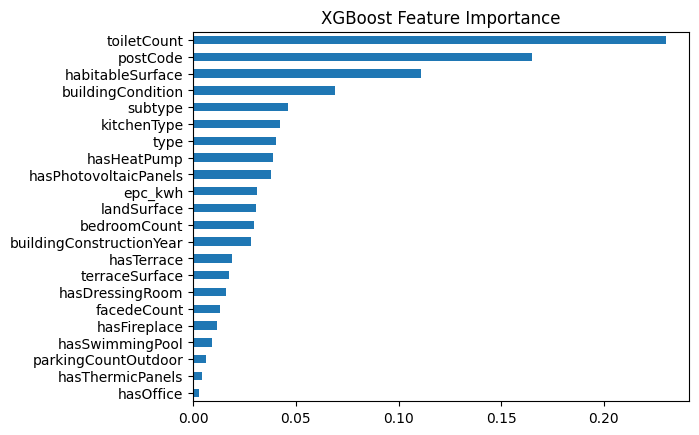

In [117]:

# Initialize XGBoost model with good default parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Get feature importance
importance = pd.Series(xgb_model.feature_importances_, index=features)
importance.sort_values(ascending=True).plot(
    kind='barh', 
    title='XGBoost Feature Importance'
)

### Evaluate Model

In [118]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Performance Metrics:")
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred) * 100, "%")
print("MAE:", mean_absolute_error(y_test, y_pred))

XGBoost Performance Metrics:
RMSE: 79664.78694468903
R² Score: 0.7415005800905949
MAPE: 18.478204349061915 %
MAE: 57605.50982533893
